#### Library

In [ ]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy
import math
import numpy as np

#### Load dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("Eugenememe/mix-en-vi-500k")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.json:   0%|          | 0.00/183M [00:00<?, ?B/s]

validation.json:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/495942 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/55105 [00:00<?, ? examples/s]

In [ ]:
print(ds.keys())
print(ds)

dict_keys(['train', 'validation'])
DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 495942
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 55105
    })
})


In [ ]:
def convert_data(example):
    return {
        "English": example["translation"]["en"],
        "Vietnamese": example["translation"]["vi"],
    }
ds = ds.map(convert_data)

Map:   0%|          | 0/495942 [00:00<?, ? examples/s]

Map:   0%|          | 0/55105 [00:00<?, ? examples/s]

In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['translation', 'English', 'Vietnamese'],
        num_rows: 495942
    })
    validation: Dataset({
        features: ['translation', 'English', 'Vietnamese'],
        num_rows: 55105
    })
})


In [ ]:
from datasets import DatasetDict

train_valid = ds  # dataset bạn đang có

train_test = train_valid["train"].train_test_split(
    test_size=0.1,
    seed=42
)

train = train_test["train"]          # 90% của train gốc
test  = train_test["test"]           # 10% của train gốc
valid = train_valid["validation"]    # giữ nguyên validation

new_ds = DatasetDict({
    "train": train,
    "validation": valid,
    "test": test
})

new_ds


DatasetDict({
    train: Dataset({
        features: ['translation', 'English', 'Vietnamese'],
        num_rows: 446347
    })
    validation: Dataset({
        features: ['translation', 'English', 'Vietnamese'],
        num_rows: 55105
    })
    test: Dataset({
        features: ['translation', 'English', 'Vietnamese'],
        num_rows: 49595
    })
})

In [ ]:
new_ds = DatasetDict({
    "train": new_ds["train"].remove_columns(["translation"]),
    "validation": new_ds["validation"].remove_columns(["translation"]),
    "test": new_ds["test"].remove_columns(["translation"]),
})
new_ds

DatasetDict({
    train: Dataset({
        features: ['English', 'Vietnamese'],
        num_rows: 446347
    })
    validation: Dataset({
        features: ['English', 'Vietnamese'],
        num_rows: 55105
    })
    test: Dataset({
        features: ['English', 'Vietnamese'],
        num_rows: 49595
    })
})

In [ ]:
train_df = pd.DataFrame(new_ds['train'])
val_df = pd.DataFrame(new_ds['validation'])
test_df = pd.DataFrame(new_ds['test'])

print("Train DataFrame head:")
display(train_df.head())

Train DataFrame head:


,English,Vietnamese
0,"The book is most famous for its vivid , arguab...","Cuốn sách nổi tiếng về tính sáng sủa , bị cho ..."
1,The post-1945 borders meant that the need for ...,Biên giới sau năm 1945 khiến nhu cầu kết nối đ...
2,Robertson went on to establish the first blood...,Robertson tiếp tục thành lập bộ máy truyền máu...
3,Research local : Banquet halls Union halls Chu...,Hãy tìm hiểu những cơ sở sau tại địa phương : ...
4,The Princess Palatine was Henrietta 's first c...,Công chúa Palatine là anh em họ đầu tiên của H...


#### EDA Original Data

##### Overview for 3 `train`, `valid`, and `test`

In [ ]:
def eda_basic(df, split_name):
    print(f"\n===== {split_name.upper()} SET =====")

    # Thông tin tổng quan
    print("\nDataFrame Info:")
    print(df.info())

    # Kiểm tra giá trị thiếu
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Kiểm tra dòng trùng lặp
    print("\nTotal duplicate rows:")
    print(df.duplicated().sum())

    # In vài dòng đầu tiên để xem cấu trúc
    print("\nSample data:")
    display(df.head())

In [ ]:
eda_basic(train_df, "train_df")
eda_basic(val_df, "validation")
eda_basic(test_df, "test")


===== TRAIN_DF SET =====

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446347 entries, 0 to 446346
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   English     446347 non-null  object
 1   Vietnamese  446347 non-null  object
dtypes: object(2)
memory usage: 6.8+ MB
None

Missing values per column:
English       0
Vietnamese    0
dtype: int64

Total duplicate rows:
4129

Sample data:


,English,Vietnamese
0,"The book is most famous for its vivid , arguab...","Cuốn sách nổi tiếng về tính sáng sủa , bị cho ..."
1,The post-1945 borders meant that the need for ...,Biên giới sau năm 1945 khiến nhu cầu kết nối đ...
2,Robertson went on to establish the first blood...,Robertson tiếp tục thành lập bộ máy truyền máu...
3,Research local : Banquet halls Union halls Chu...,Hãy tìm hiểu những cơ sở sau tại địa phương : ...
4,The Princess Palatine was Henrietta 's first c...,Công chúa Palatine là anh em họ đầu tiên của H...



===== VALIDATION SET =====

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55105 entries, 0 to 55104
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   English     55105 non-null  object
 1   Vietnamese  55105 non-null  object
dtypes: object(2)
memory usage: 861.1+ KB
None

Missing values per column:
English       0
Vietnamese    0
dtype: int64

Total duplicate rows:
145

Sample data:


,English,Vietnamese
0,"Nintendo later released the Nintendo Channel ,...","Nintendo sau đó phát hành kênh Nintendo , cho ..."
1,"'Cause, baby, you know I'd do anything for you...","Vì anh biết đấy cưng, em sẽ làm mọi thứ vì anh..."
2,If you're gonna treat me like an insane person...,Nếu anh định đối xử với em như kẻ mất trí và b...
3,"In northern and western Europe, vegetable prod...","Ở Bắc và Tây Âu, các nhà sản xuất rau có thể t..."
4,Was it a truth serum that could be used in int...,Nó có thể là thuốc sự thật có thể dùng trong t...



===== TEST SET =====

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49595 entries, 0 to 49594
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   English     49595 non-null  object
 1   Vietnamese  49595 non-null  object
dtypes: object(2)
memory usage: 775.1+ KB
None

Missing values per column:
English       0
Vietnamese    0
dtype: int64

Total duplicate rows:
122

Sample data:


,English,Vietnamese
0,"Lieutenant, Robbery-Homicide, Major Crime Unit.","Trung úy, Ban trộm cắp và giết người. Đơn vị T..."
1,It's all right. It's all right.,Ổn mà. Sẽ ổn thôi.
2,"As with most exoplanets , the name "" Kepler - ...","Như với hầu hết các ngoại hành tinh , cái tên ..."
3,"Jerry's staying on, so do your best not to eng...","Anh ấy ở lại, cố gắng đừng đánh động tới cô bé."
4,Characteristic of the remaining bronze periods...,Đặc trưng của các thời kỳ đồ đồng còn lại là n...


##### Detail for `train` dataset

Phân bố độ dài câu

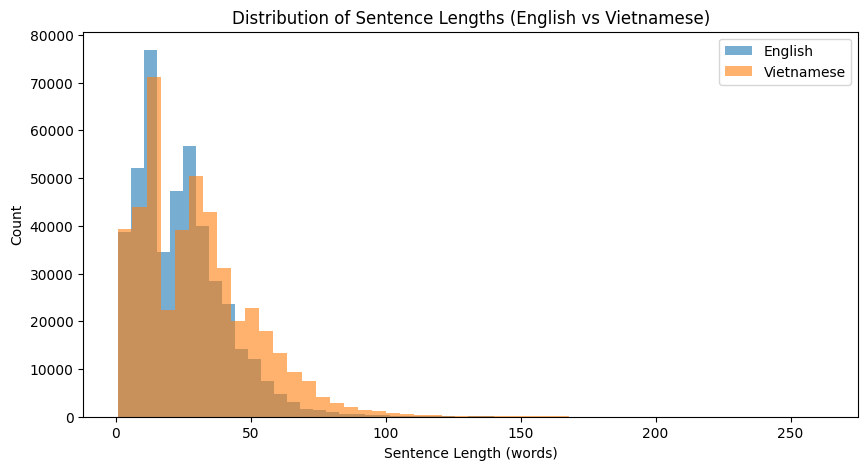

In [ ]:
train_df['en_len'] = train_df['English'].apply(lambda x: len(x.split()))
train_df['vi_len'] = train_df['Vietnamese'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.hist(train_df['en_len'], bins=50, alpha=0.6, label='English')
plt.hist(train_df['vi_len'], bins=50, alpha=0.6, label='Vietnamese')
plt.xlabel("Sentence Length (words)")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Sentence Lengths (English vs Vietnamese)")
plt.show()

Tỷ lệ độ dài En/Vi (độ khớp giữa 2 ngôn ngữ)

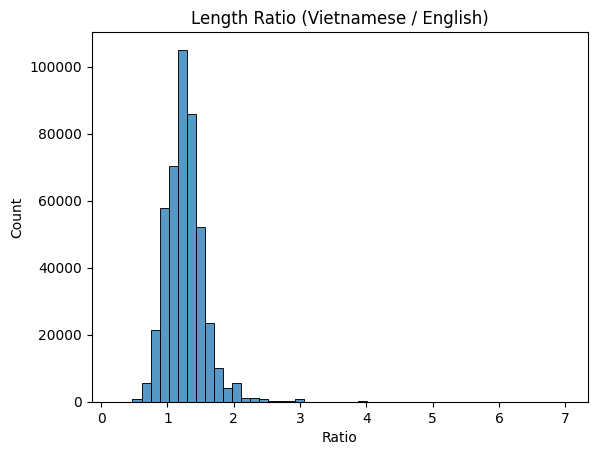

In [ ]:
train_df['len_ratio'] = train_df['vi_len'] / train_df['en_len']
sns.histplot(train_df['len_ratio'], bins=50)
plt.title("Length Ratio (Vietnamese / English)")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.show()

In [ ]:
# Cặp có độ lệch lớn
outliers = train_df[(train_df['len_ratio'] == 3.0)]

# In tổng số cặp bị lệch
# print(f"Tổng số cặp bị lệch độ dài: {len(outliers)}")

# Hiển thị vài ví dụ đầu
from IPython.display import display
display(outliers[['English', 'Vietnamese', 'en_len', 'vi_len', 'len_ratio']].head(10))


,English,Vietnamese,en_len,vi_len,len_ratio
143,-Yeah. -Boys?,- Ừ. - Con trai nhỉ?,2,6,3.0
370,Thanks.,Cảm ơn anh.,1,3,3.0
764,intimidation...,sự đe dọa...,1,3,3.0
1235,Anybody?,Ai biết không?,1,3,3.0
1367,Please.,Làm ơn đi.,1,3,3.0
2082,-Yeah. -Yeah.,- Có ạ. - Thế à?,2,6,3.0
2438,Motherfucker.,Thằng súc vật.,1,3,3.0
2962,Podiatrist.,Bác sĩ chân.,1,3,3.0
4638,Please.,Làm ơn đi.,1,3,3.0
4883,Reciprocal.,Hỗ trợ nhau.,1,3,3.0


Thống kê mô tả độ dài (mean, median, std)

Mục đích của thống kê này là để chọn tham số max_length hợp lý khi tokenize. Khi huấn luyện mô hình dịch (như ViT5, mT5, MarianMT) cần phải đặt tham số max_length.
 * Nếu max_length quá thấp → cắt mất nội dung câu.
 * Nếu quá cao → lãng phí bộ nhớ, tốc độ train chậm.

In [ ]:
print("English length stats:")
print(train_df['en_len'].describe())

print("\nVietnamese length stats:")
print(train_df['vi_len'].describe())

English length stats:
count    446347.000000
mean         24.260239
std          16.434104
min           1.000000
25%          12.000000
50%          22.000000
75%          33.000000
max         241.000000
Name: en_len, dtype: float64

Vietnamese length stats:
count    446347.000000
mean         30.471071
std          21.312977
min           1.000000
25%          13.000000
50%          28.000000
75%          41.000000
max         262.000000
Name: vi_len, dtype: float64


Từ phổ biến nhất (Word Frequency)

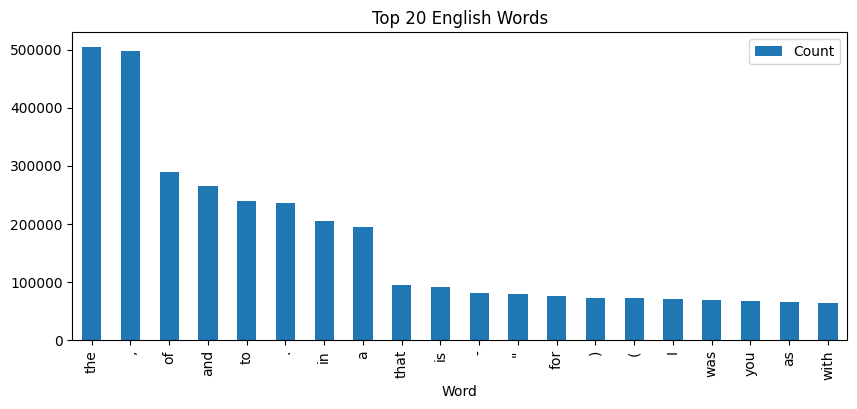

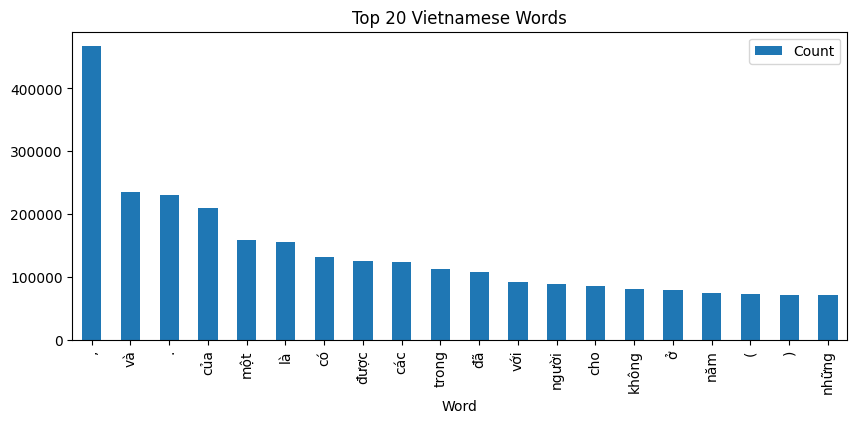

In [ ]:
en_words = ' '.join(train_df['English']).split()
vi_words = ' '.join(train_df['Vietnamese']).split()

en_common = Counter(en_words).most_common(20)
vi_common = Counter(vi_words).most_common(20)

pd.DataFrame(en_common, columns=['Word', 'Count']).plot.bar(x='Word', y='Count', title='Top 20 English Words', figsize=(10,4))
pd.DataFrame(vi_common, columns=['Word', 'Count']).plot.bar(x='Word', y='Count', title='Top 20 Vietnamese Words', figsize=(10,4))
plt.show()


Heatmap tương quan độ dài En–Vi

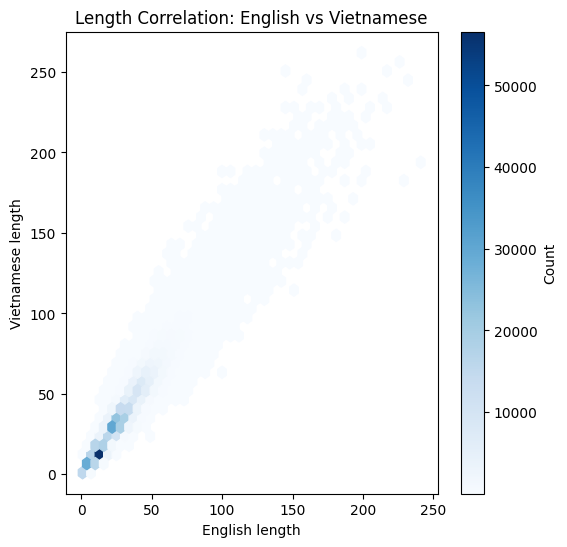

In [ ]:
plt.figure(figsize=(6,6))
plt.hexbin(train_df['en_len'], train_df['vi_len'], gridsize=40, cmap='Blues', mincnt=1)
plt.xlabel('English length')
plt.ylabel('Vietnamese length')
plt.title('Length Correlation: English vs Vietnamese')
plt.colorbar(label='Count')
plt.show()

Phân bố chính tập trung gần đường chéo (y ≈ x). Điều này cho thấy độ dài câu giữa hai ngôn ngữ có mối tương quan tuyến tính mạnh. Khi câu tiếng Anh dài hơn, câu tiếng Việt cũng dài hơn tương ứng.

Phần lớn dữ liệu tập trung tại vùng 5–15 (English) và 7–20 (Vietnamese). Có thể thấy đa phần các câu trong dữ liệu ngắn hoặc trung bình.

Không có dấu hiệu lệch hoặc nhiễu.

In [ ]:
corr = train_df['en_len'].corr(train_df['vi_len'])
print(f"Hệ số tương quan Pearson giữa độ dài câu: {corr:.3f}")

Hệ số tương quan Pearson giữa độ dài câu: 0.964


Hệ số tương quan giữa độ dài câu tiếng Anh và tiếng Việt đạt r ≈ 0.833, cho thấy hai ngôn ngữ có mức độ tương ứng cao về mặt cấu trúc.

In [ ]:
display(train_df.head())

,English,Vietnamese,en_len,vi_len,len_ratio
0,"The book is most famous for its vivid , arguab...","Cuốn sách nổi tiếng về tính sáng sủa , bị cho ...",35,64,1.828571
1,The post-1945 borders meant that the need for ...,Biên giới sau năm 1945 khiến nhu cầu kết nối đ...,40,50,1.250000
2,Robertson went on to establish the first blood...,Robertson tiếp tục thành lập bộ máy truyền máu...,25,28,1.120000
3,Research local : Banquet halls Union halls Chu...,Hãy tìm hiểu những cơ sở sau tại địa phương : ...,35,63,1.800000
4,The Princess Palatine was Henrietta 's first c...,Công chúa Palatine là anh em họ đầu tiên của H...,44,50,1.136364


#### Data Preproccessing

In [ ]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=859a03b970a3aae744b895ff57f7172c6a16893ae2d072e2001fd606924ac0a4
  Stored in directory: /root/.cache/pip/wheels/3c/bc/9d/266e27289b9019680d65d9b608c37bff1eff565b001c977ec5
Successfully built langid


In [ ]:
from datasets import load_dataset, concatenate_datasets
import html, re, unicodedata
from bs4 import BeautifulSoup
import langid
import regex

In [ ]:
# =======================
# CLEAN TEXT FUNCTION
# =======================
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # 0) Trim và bảo đảm là str
    text = str(text).strip()

    # 1) Remove HTML + decode entities
    text = BeautifulSoup(text, "html.parser").get_text()
    text = html.unescape(text)

    # 2) Unicode normalize
    text = unicodedata.normalize("NFC", text)

    # Remove leading hyphen
    text = re.sub(r"^\s*-\s*", "", text)


    # 3) Remove zero-width + control chars early
    text = re.sub(r"[\u200B-\u200F\uFEFF\x00-\x1F\x7F]", " ", text)

    # 4) Replace fancy punctuation
    text = text.replace("’", "'").replace("‘", "'")
    text = text.replace("“", '"').replace("”", '"')
    text = text.replace("⋯", "…")
    text = text.replace("...", "…")

    # 5) Remove URLs, emails, tags
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"\S+@\S+", "", text)
    text = re.sub(r"[@#]\w+", "", text)

    # 6) Convert repeated dash sequences to em-dash with spaces around (but keep single hyphen)
    text = re.sub(r"[\u2012\u2013\u2014\u2015\-]{2,}", " — ", text)

    # 7) Remove uncommon symbols
    text = re.sub(r"[◆●■♡→•※✦►◄▽▼▲♦★☆■□▪▫]", "", text)

    # 8) Preserve Vietnamese letters but remove weird chars:
    # allow letters (including Vietnamese range), digits, basic punctuation and some symbols
    text = re.sub(r"[^0-9A-Za-zÀ-ỹà-ỹẠ-ỹạ-ỹ \t\n\r\.,!\?\;:\'\"\-\(\)\/%—…]", " ", text)

    # 9. Fix multiple punctuation repeats: ellipsis etc.
    # first collapse any "dot + spaces + dot + spaces + dot" variants into '...'
    text = re.sub(r"\.\s*\.\s*\.+", "...", text)   # . . .  or .... -> ...
    text = re.sub(r"\.{4,}", "...", text)          # more than 3 -> ...
    # normalize sequences of 2 dots -> single dot (we treat .. -> .)
    text = re.sub(r"\.{2}", ".", text)
    # repeated commas/exclam/question
    text = re.sub(r",{2,}", ",", text)
    text = re.sub(r"!{2,}", "!", text)
    text = re.sub(r"\?{2,}", "?", text)

    # 10) Allow only valid characters (EN + VI + punctuation)
    # text = re.sub(r"[^0-9A-Za-zÀ-ỹ ,.!?;:'\"()\-\%/…]", " ", text)
    text = regex.sub(r"[^\p{Letter}\p{Number}\p{Punctuation}\p{Separator}]", " ", text)

    # 11) Normalize repeating chars (soooo → soo)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # 12) Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()
    # === FIX: Add space before single-quote starting a phrase ===
    # Example: chọn ' Download ' → chọn 'Download'
    #          chọn'Download'   → chọn 'Download'
    text = re.sub(r"(?<=\S)'\s*(?=\w)", r" '", text)


    # === FIX: add space before quote starting a phrase ===
    # text = re.sub(r"(?<=\S)'(?=[A-Za-zÀ-ỹ])", r" '", text)


    # 13) Fix punctuation spacing safely (quotes, apostrophes, periods)

    # 13.1 Fix space BEFORE punctuation (except opening quotes)
    text = re.sub(r"\s+([,.!?;:])", r"\1", text)

    # 13.2 Fix space BEFORE closing quote
    text = re.sub(r'\s+(")', r'\1', text)

    # 13.3 Fix spacing for possessive 's (Truman's)
    text = re.sub(r"\s+'s\b", r"'s", text)

    # 13.4 Add space AFTER punctuation if missing (but NOT for apostrophes)
    text = re.sub(r"([,.!?;:])([A-Za-z0-9])", r"\1 \2", text)

    # 13.5 Ensure space before opening quote and no space after it
    text = re.sub(r'\s*"\s*([A-Za-z])', r' "\1', text)


    # 13.6 Fix closing quotes: remove space before punctuation
    text = re.sub(r'" ([,.!?;:])', r'"\1', text)

    # Remove space just before closing single quote: abc  ' -> abc'
    text = re.sub(r"([A-Za-zÀ-ỹ0-9])\s+'", r"\1'", text)



    # 14) Fix stuck parentheses
    text = re.sub(r"\(\s+", "(", text)
    text = re.sub(r"\s+\)", ")", text)

    # 15) Fix "'s"
    text = re.sub(r"\s+'s\b", "'s", text)

    # 16) Fix spaces in abbreviations composed of capital letters with dots:
    # Examples to handle: "U. S. ,", "U. K. ,", "D. C." etc.
    # Step: remove spaces between single capitals and dots: "U. S." -> "U.S."
    text = re.sub(r"\b([A-Z])\.\s+([A-Z])\.", r"\1.\2.", text)
    # If longer sequences like "U. S. A." -> "U.S.A."
    # loop until no change (to collapse chains)
    prev = None
    while prev != text:
        prev = text
        text = re.sub(r"\b([A-Z])\.\s+([A-Z])\.", r"\1.\2.", text)

    # 17) Remove spaces after dots within abbreviations: "U.S. , " -> "U.S.,"
    text = re.sub(r"([A-Z]\.)\s+,", r"\1,", text)

    # 18) Fix digits separated by comma + space like "12, 00" -> "12,00"
    text = re.sub(r"(\d)\s*,\s*(\d)", r"\1,\2", text)

    # 19) Fix English + Vietnamese stuck together
    text = regex.sub(r"([A-Za-z])(\p{Letter}&&\p{Script=Latin}&&\p{M}?)", r"\1 \2", text)

    # 20) Final trim
    text = re.sub(r"[\u200B-\u200F\uFEFF]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    return text


# ==========================
# PREPROCESS FUNCTION
# ==========================
def preprocess_text(text):
    text = clean_text(text)
    return text

print("=== ORIGINAL COUNTS ===")
print("Train:", len(train_df))
print("Valid:", len(val_df))
print("Test :", len(test_df))


# =======================
# PREPROCESS
# =======================
print("Preprocess on train...")
train_df["en"] = train_df["English"].apply(preprocess_text)
train_df["vi"] = train_df["Vietnamese"].apply(preprocess_text)

# print("Preprocess on valid...")
val_df["en"] = val_df["English"].apply(preprocess_text)
val_df["vi"] = val_df["Vietnamese"].apply(preprocess_text)

# print("Preprocess on test...")
test_df["en"] = test_df["English"].apply(preprocess_text)
test_df["vi"] = test_df["Vietnamese"].apply(preprocess_text)

print("\n=== AFTER CLEAN ===")
print("Train:", len(train_df))
print("Valid:", len(val_df))
print("Test :", len(test_df))


# =======================
# REMOVE EMPTY ROWS
# =======================
print("Remove empty rows on train...")
train_df = train_df[(train_df["en"].str.strip() != "") & (train_df["vi"].str.strip() != "")]

print("Remove empty rows on valid...")
val_df   = val_df[(val_df["en"].str.strip() != "") & (val_df["vi"].str.strip() != "")]

print("Remove empty rows on test...")
test_df  = test_df[(test_df["en"].str.strip() != "") & (test_df["vi"].str.strip() != "")]

print("\n=== AFTER REMOVE EMPTY ===")
print("Train:", len(train_df))
print("Valid:", len(val_df))
print("Test :", len(test_df))


# =======================
# REMOVE DUPLICATES
# =======================
print("Remove duplicate rows on train...")
train_df = train_df.drop_duplicates(subset=["en", "vi"])

print("Remove duplicate rows on valid...")
val_df   = val_df.drop_duplicates(subset=["en", "vi"])

print("Remove duplicate rows on test...")
test_df  = test_df.drop_duplicates(subset=["en", "vi"])

print("\n=== AFTER REMOVE DUPLICATES ===")
print("Train:", len(train_df))
print("Valid:", len(val_df))
print("Test :", len(test_df))


# =========================
# FILTER BY SENTENCE LENGTH
# =========================
print("Filter length on train...")
train_df = train_df[
    train_df["en"].str.split().str.len().between(1, 80) &
    train_df["vi"].str.split().str.len().between(1, 80)
]

print("Filter length on valid...")
val_df = val_df[
    val_df["en"].str.split().str.len().between(1, 80) &
    val_df["vi"].str.split().str.len().between(1, 80)
]

print("Filter length on test...")
test_df = test_df[
    test_df["en"].str.split().str.len().between(1, 80) &
    test_df["vi"].str.split().str.len().between(1, 80)
]

print("\n=== AFTER LENGTH FILTER ===")
print("Train:", len(train_df))
print("Valid:", len(val_df))
print("Test :", len(test_df))


# =================
# FILTER BY LANGID
# =================
langid.set_languages(["en", "vi"])

# ---- Train ----
print("Filter language on train...")
train_lang_mask = (
    (train_df["en"].apply(lambda x: langid.classify(x)[0]) == "en") &
    (train_df["vi"].apply(lambda x: langid.classify(x)[0]) == "vi")
)

train_removed_df = train_df[~train_lang_mask]  # lưu mẫu bị loại
train_df = train_df[train_lang_mask]           # giữ lại mẫu đúng

# ---- Val ----
print("Filter language on valid...")
val_lang_mask = (
    (val_df["en"].apply(lambda x: langid.classify(x)[0]) == "en") &
    (val_df["vi"].apply(lambda x: langid.classify(x)[0]) == "vi")
)

val_removed_df = val_df[~val_lang_mask]
val_df = val_df[val_lang_mask]

# ---- Test ----
print("Filter language on test...")
test_lang_mask = (
    (test_df["en"].apply(lambda x: langid.classify(x)[0]) == "en") &
    (test_df["vi"].apply(lambda x: langid.classify(x)[0]) == "vi")
)

test_removed_df = test_df[~test_lang_mask]
test_df = test_df[test_lang_mask]

print("\n=== AFTER LANGID FILTER ===")
print(f"Train: {len(train_df)} (removed: {len(train_removed_df)})")
print(f"Valid: {len(val_df)} (removed: {len(val_removed_df)})")
print(f"Test : {len(test_df)} (removed: {len(test_removed_df)})")

=== ORIGINAL COUNTS ===
Train: 446347
Valid: 55105
Test : 49595
Preprocess on train...

=== AFTER CLEAN ===
Train: 446347
Valid: 55105
Test : 49595
Remove empty rows on train...
Remove empty rows on valid...
Remove empty rows on test...

=== AFTER REMOVE EMPTY ===
Train: 446347
Valid: 55105
Test : 49595
Remove duplicate rows on train...
Remove duplicate rows on valid...
Remove duplicate rows on test...

=== AFTER REMOVE DUPLICATES ===
Train: 439921
Valid: 54919
Test : 49444
Filter length on train...
Filter length on valid...
Filter length on test...

=== AFTER LENGTH FILTER ===
Train: 433379
Valid: 54143
Test : 48695
Filter language on train...
Filter language on valid...
Filter language on test...

=== AFTER LANGID FILTER ===
Train: 432284 (removed: 1095)
Valid: 54007 (removed: 136)
Test : 48569 (removed: 126)


In [ ]:
# train_df = train_df.rename(columns={
#     "vi": "input_text",
#     "en": "target_text"
# })

# val_df = val_df.rename(columns={
#     "vi": "input_text",
#     "en": "target_text"
# })

# test_df = test_df.rename(columns={
#     "vi": "input_text",
#     "en": "target_text"
# })


In [ ]:
from datasets import Dataset

def df_to_hfds(df):
    ds = Dataset.from_pandas(df.reset_index(drop=True))
    if "__index_level_0__" in ds.column_names:
        ds = ds.remove_columns(["__index_level_0__"])
    return ds

ds_train = df_to_hfds(train_df)
ds_valid = df_to_hfds(val_df)
ds_test  = df_to_hfds(test_df)

In [ ]:
# =======================
# PREFIX BUILDING
# =======================
def to_prefix_vi2en(example):
    """Prefix cho Việt → Anh"""
    prefix = f"vi_en: {example['vi']}"
    return {'input_text': prefix, 'target_text': example['en']}


print("Mapping to prefix on train...")
ds_vi2en_train = ds_train.map(to_prefix_vi2en, \
                              remove_columns=ds_train.column_names, \
                              num_proc=4)

print("Mapping to prefix on valid...")
ds_vi2en_valid = ds_valid.map(to_prefix_vi2en, \
                              remove_columns=ds_valid.column_names, \
                              num_proc=2)

print("Mapping to prefix on test...")
ds_vi2en_test = ds_test.map(to_prefix_vi2en, \
                            remove_columns=ds_test.column_names, \
                            num_proc=2)

Mapping to prefix on train...


Map (num_proc=4):   0%|          | 0/432284 [00:00<?, ? examples/s]

Mapping to prefix on valid...


Map (num_proc=2):   0%|          | 0/54007 [00:00<?, ? examples/s]

Mapping to prefix on test...


Map (num_proc=2):   0%|          | 0/48569 [00:00<?, ? examples/s]

In [ ]:
print(f"train: {len(ds_vi2en_train)} samples, valid: {len(ds_vi2en_valid)} samples, "
      f"test: {len(ds_vi2en_test)} samples")

train: 432284 samples, valid: 54007 samples, test: 48569 samples


In [ ]:
for i in range(5):
    print(ds_vi2en_train[i])
    print("------")

{'input_text': 'vi_en: Cuốn sách nổi tiếng về tính sáng sủa, bị cho là mang nhiều yếu tố chủ quan, phác hoạ hình ảnh những trận chiến của Frederick, trong tác phẩm, Carlyle đã truyền đạt được góc nhìn của ông về toàn cảnh của sự hỗn loạn cực độ được nhà lãnh đạo xuất chúng xử lý một cách tài tình.', 'target_text': "The book is most famous for its vivid, arguably very biased, portrayal of Frederick's battles, in which Carlyle communicated his vision of almost overwhelming chaos mastered by leadership of genius."}
------
{'input_text': 'vi_en: Biên giới sau năm 1945 khiến nhu cầu kết nối đường bộ công suất cao trên tuyến đường đó đã biến mất và mặc dù phần lớn công việc xây dựng đã được thực hiện, nhưng nó không được chính phủ Ba Lan tiếp tục sau chiến tranh.', 'target_text': 'The post-1945 borders meant that the need for a high - capacity road connection on that route disappeared and even though much of the construction work was already done, it was not continued by the postwar Polish g

In [ ]:
n = len(ds_vi2en_train)
ds_train[n-5 : n]

{'English': ['In the early summer of 1876 , Allen was elected by the Nuttall Ornithological Club to replace Charles Johnson Maynard and Henry Augustus Purdie as editor of their Bulletin .',
  'Section 247 of the Income Tax Act ( Canada ) Information Circular 87 - 2R - International Transfer Pricing ( 1999 ) Information Circular 94 - 4R - International Transfer Pricing : Advance Pricing Arrangements ( APAs ) ( 2001 ) TPM 07 - Referrals to the Transfer Pricing Review Committee ( 2005 ) TPM 09 - Reasonable efforts under section 247 of the Income Tax Act ( 2006 )',
  'Unibeast and MacPwn were updated to support El Capitan as well , since El Capitan , Unibeast ( and Multibeast ) use the Clover bootloader instead of Chimera ( a Chameleon - based bootloader ) .',
  'In the 19th century , the number of Jews grew in Niebylec , and by the early 20th century , they made the majority of the population .',
  'Around 200km west of Hanoi, the commune, named after a mountain that it hosts, is an emerg

#### Model

In [ ]:
ds_vi2en_train.save_to_disk("train")
ds_vi2en_valid.save_to_disk("valid")
ds_vi2en_test.save_to_disk("test")

In [ ]:
!pip install protobuf==3.20.*
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score sacrebleu

In [ ]:
%%writefile mt_train_script.py

from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, EarlyStoppingCallback



import evaluate
import torch
import numpy as np

# LOAD DATASET
ds_train = load_from_disk("train")
ds_valid = load_from_disk("valid")


# LOAD MODEL & TOKENIZER

MODEL_NAME = "VietAI/ViT5-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)





# TOKENIZE FUNCTION
def tokenize_fn(batch):
    model_inputs = tokenizer(
        batch["input_text"],
        max_length=64,
        padding="max_length",
        truncation=True,
    )

    labels = tokenizer(
        batch["target_text"],
        max_length=64,
        padding="max_length",
        truncation=True,
    )["input_ids"]

    labels = [
        [(t if t != tokenizer.pad_token_id else -100) for t in label]
        for label in labels
    ]

    model_inputs["labels"] = labels
    return model_inputs

train_tok = ds_train.map(tokenize_fn, batched=True, remove_columns=ds_train.column_names)
valid_tok = ds_valid.map(tokenize_fn, batched=True, remove_columns=ds_valid.column_names)




# METRIC (BLEU)
metric = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result






# TRAINING ARGUMENTS
training_args = Seq2SeqTrainingArguments(
    output_dir="./nlp_mt_endterm_vi_en_v5_data400k",
    eval_strategy="steps",
    eval_steps=6000,

    save_strategy="steps",
    save_steps=6000,

    logging_strategy="steps",
    logging_steps=1000,

    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,

    num_train_epochs=10,
    learning_rate=1e-4,
    warmup_ratio=0.05,
    label_smoothing_factor=0.1,
    weight_decay=0.01,


    fp16=True,
    report_to="none",
    run_name="vit5_en_vi_ft",
    group_by_length=True,
    gradient_checkpointing=True,
    predict_with_generate=True,

    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True
)





# TRAINER
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=valid_tok,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3)  # STOP nếu BLEU không cải thiện 3 lần liên tiếp
    ]
)





# TRAIN
trainer.train()
trainer.save_state()

Writing mt_train_script.py


In [ ]:
!pip install accelerate

In [ ]:
!accelerate config default

In [ ]:
!accelerate launch mt_train_script.py

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

##### draft

In [ ]:
# print(model)

In [ ]:
# print(model.config)

In [ ]:
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total parameters: {total_params:,}")

In [ ]:
# def tokenize_fn(batch):
#     model_inputs = tokenizer(
#         batch["input_text"],
#         max_length=64,
#         padding="max_length",
#         truncation=True,
#     )

#     labels = tokenizer(
#         batch["target_text"],
#         max_length=64,
#         padding="max_length",
#         truncation=True,
#     )["input_ids"]

#     labels = [
#         [(t if t != tokenizer.pad_token_id else -100) for t in label]
#         for label in labels
#     ]

#     model_inputs["labels"] = labels
#     return model_inputs

# train_tok = ds_train_bi.map(tokenize_fn, batched=True, remove_columns=ds_train_bi.column_names)
# valid_tok = ds_valid_bi.map(tokenize_fn, batched=True, remove_columns=ds_valid_bi.column_names)
# test_tok  = ds_test_bi.map(tokenize_fn,  batched=True, remove_columns=ds_test_bi.column_names)

In [ ]:
# metric = evaluate.load("sacrebleu")

# def postprocess_text(preds, labels):
#     preds = [pred.strip() for pred in preds]
#     labels = [[label.strip()] for label in labels]

#     return preds, labels


# def compute_metrics(eval_preds):
#     preds, labels = eval_preds
#     if isinstance(preds, tuple):
#         preds = preds[0]
#     decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

#     result = metric.compute(predictions=decoded_preds, references=decoded_labels)
#     result = {"bleu": result["score"]}

#     prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
#     result["gen_len"] = np.mean(prediction_lens)
#     result = {k: round(v, 4) for k, v in result.items()}
#     return result

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

# push_to_hub=True
# hub_model_id="tnguyen20604/nlp_mt_endterm_v4_data400k"

In [ ]:
# from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

# training_args = Seq2SeqTrainingArguments(
#     output_dir="./nlp_mt_endterm_v4_data400k",
#     eval_strategy="steps",
#     eval_steps=20000,

#     save_strategy="epoch",
#     push_to_hub=True,
#     hub_model_id="tnguyen20604/nlp_mt_endterm_v4_data400k",
#     hub_strategy="every_save",
#     hub_private_repo=False,

#     logging_strategy="steps",
#     logging_steps=20000,

#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     gradient_accumulation_steps=2,

#     num_train_epochs=3,
#     learning_rate=1e-4,
#     warmup_ratio=0.05,
#     label_smoothing_factor=0.1,
#     weight_decay=0.01,


#     fp16=True,
#     report_to="none",
#     run_name="vit5_en_vi_ft",
#     group_by_length=True,
#     # gradient_checkpointing=True,
#     predict_with_generate=True,
# )


In [ ]:
# data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# trainer = Seq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_tok,
#     eval_dataset=valid_tok,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
#     compute_metrics=compute_metrics
# )

In [ ]:
# trainer.train()

In [ ]:
# import json
# import pandas as pd
# import matplotlib.pyplot as plt

# with open("mt_output/trainer_state.json", "r") as f:
#     state = json.load(f)

# logs = state["log_history"]

# df = pd.DataFrame(logs)

# train_df = df[df["loss"].notnull()]
# val_df = df[df["eval_loss"].notnull()]

# plt.figure(figsize=(10,5))
# plt.plot(train_df["step"], train_df["loss"], label="Train Loss")
# plt.plot(val_df["step"], val_df["eval_loss"], label="Validation Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

#### Test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/checkpoint-33780.zip

Archive:  /content/drive/MyDrive/checkpoint-33780.zip
   creating: checkpoint-33780/
  inflating: checkpoint-33780/config.json  
  inflating: checkpoint-33780/generation_config.json  
  inflating: checkpoint-33780/model.safetensors  
  inflating: checkpoint-33780/optimizer.pt  
  inflating: checkpoint-33780/rng_state_0.pth  
  inflating: checkpoint-33780/rng_state_1.pth  
  inflating: checkpoint-33780/scaler.pt  
  inflating: checkpoint-33780/scheduler.pt  
  inflating: checkpoint-33780/special_tokens_map.json  
  inflating: checkpoint-33780/spiece.model  
  inflating: checkpoint-33780/tokenizer.json  
  inflating: checkpoint-33780/tokenizer_config.json  
  inflating: checkpoint-33780/trainer_state.json  
  inflating: checkpoint-33780/training_args.bin  


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "/content/checkpoint-33780"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).to("cuda")

text = "vi_en: Đêm trường trung cổ là nỗi ám ảnh kinh hoàng của lịch sử châu Âu"
inputs = tokenizer(text, return_tensors="pt").to("cuda")
output = model.generate(**inputs, max_length=64)
print(tokenizer.decode(output[0], skip_special_tokens=True))

The night of medieval schools is the horrific obsession of European history


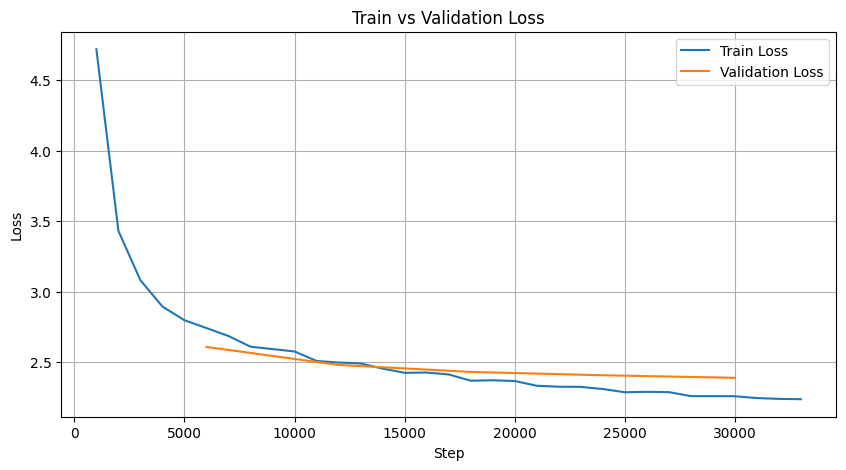

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

state_path = "/content/checkpoint-33780/trainer_state.json"

with open(state_path, "r") as f:
    state = json.load(f)

logs = state["log_history"]

df = pd.DataFrame(logs)

train_df = df[df["loss"].notnull()]
val_df   = df[df["eval_loss"].notnull()]

plt.figure(figsize=(10,5))
plt.plot(train_df["step"], train_df["loss"], label="Train Loss")
plt.plot(val_df["step"], val_df["eval_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

#### Push to Hugging Face

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import create_repo
create_repo("machine-translation-v1-data400k", private=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RepoUrl('https://huggingface.co/tnguyen20604/machine-translation-v1-data400k', endpoint='https://huggingface.co', repo_type='model', repo_id='tnguyen20604/machine-translation-v1-data400k')

In [ ]:
from huggingface_hub import upload_folder

upload_folder(
    repo_id="tnguyen20604/machine-translation-v1-data400k",
    folder_path="checkpoint-33780",
    commit_message="Upload checkpoint"
)

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...kpoint-33780/spiece.model: 100%|##########|  820kB /  820kB            

  ...heckpoint-33780/scaler.pt: 100%|##########|   988B /   988B            

  ...kpoint-33780/optimizer.pt:   0%|          | 38.2kB / 1.81GB            

  ...t-33780/model.safetensors:   0%|          |  555kB /  904MB            

  ...int-33780/rng_state_0.pth:  12%|#2        | 1.75kB / 14.5kB            

  ...int-33780/rng_state_1.pth:  12%|#2        | 1.75kB / 14.5kB            

  ...kpoint-33780/scheduler.pt:  12%|#2        |   128B / 1.06kB            

  ...t-33780/training_args.bin:  12%|#2        |   664B / 5.50kB            

CommitInfo(commit_url='https://huggingface.co/tnguyen20604/machine-translation-v1-data400k/commit/4ec9cef094c38ab072304b29eaf18cded4ce4f29', commit_message='Upload checkpoint', commit_description='', oid='4ec9cef094c38ab072304b29eaf18cded4ce4f29', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tnguyen20604/machine-translation-v1-data400k', endpoint='https://huggingface.co', repo_type='model', repo_id='tnguyen20604/machine-translation-v1-data400k'), pr_revision=None, pr_num=None)

In [ ]:
# text = "vi_en: Ước mơ của tôi là giàu có hơn"
# inputs = tokenizer(text, return_tensors="pt").to("cuda")

# output = model.generate(**inputs, max_length=64)
# print(tokenizer.decode(output[0], skip_special_tokens=True))

#### Download fine-tuning model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("tnguyen20604/machine-translation-v1-data400k")

model = AutoModelForSeq2SeqLM.from_pretrained(
    "tnguyen20604/machine-translation-v1-data400k",
    torch_dtype="float16",
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
text = "vi_en: Đêm trường trung cổ là nỗi ám ảnh kinh hoàng của lịch sử châu Âu"
inputs = tokenizer(text, return_tensors="pt").to("cuda")

output = model.generate(**inputs, max_length=64)
print(tokenizer.decode(output[0], skip_special_tokens=True))

The night of medieval schools is the horrific obsession of European history


#### Evaluate

##### a)

In [ ]:
!pip install evaluate
!pip install sacrebleu
!pip install rouge_score sacrebleu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=424f395b15be02485a29657a09f4db9cb89da5f06089f4673895a79cdf26a47d
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
import evaluate

In [ ]:
def tokenize_fn(batch):
    model_inputs = tokenizer(
        batch["input_text"],
        max_length=64,
        padding="max_length",
        truncation=True,
    )

    labels = tokenizer(
        batch["target_text"],
        max_length=64,
        padding="max_length",
        truncation=True,
    )["input_ids"]

    labels = [
        [(t if t != tokenizer.pad_token_id else -100) for t in label]
        for label in labels
    ]

    model_inputs["labels"] = labels
    return model_inputs

# train_tok = ds_train.map(tokenize_fn, batched=True, remove_columns=ds_train_bi.column_names)
# valid_tok = ds_valid.map(tokenize_fn, batched=True, remove_columns=ds_valid_bi.column_names)
test_tok  = ds_vi2en_test.map(tokenize_fn,  batched=True, remove_columns=ds_vi2en_test.column_names)

Map:   0%|          | 0/48569 [00:00<?, ? examples/s]

In [ ]:
def batch_generate(model, tokenizer, texts, batch_size=32):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=64
        ).to("cuda")

        outputs = model.generate(
            **inputs,
            max_length=64,
            num_beams=1   # nhanh nhất
        )

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        preds.extend(decoded)

    return preds

In [ ]:
# Chuẩn bị dữ liệu
texts = [item["input_text"] for item in ds_vi2en_test]
refs  = [item["target_text"] for item in ds_vi2en_test]

# Generate
preds = batch_generate(model, tokenizer, texts, batch_size=32)

In [ ]:
bleu = evaluate.load("sacrebleu")
chrf = evaluate.load("chrf")
rouge = evaluate.load("rouge")

bleu_res = bleu.compute(predictions=preds, references=refs)
chrf_res = chrf.compute(predictions=preds, references=refs)
rouge_res = rouge.compute(predictions=preds, references=refs)

print("BLEU:", bleu_res)
print("chrF:", chrf_res)
print("ROUGE:", rouge_res)

BLEU: {'score': 38.867884766285115, 'counts': [759800, 494991, 351331, 257333], 'totals': [1081442, 1032873, 984304, 935899], 'precisions': [70.25804435189312, 47.923704075912525, 35.69334270713113, 27.49580884262084], 'bp': 0.9116242460364187, 'sys_len': 1081442, 'ref_len': 1181505}
chrF: {'score': 60.68898989411334, 'char_order': 6, 'word_order': 0, 'beta': 2}
ROUGE: {'rouge1': np.float64(0.6492333236537013), 'rouge2': np.float64(0.4313577237307018), 'rougeL': np.float64(0.6228390168258264), 'rougeLsum': np.float64(0.6229138626774262)}


In [ ]:
metric = evaluate.load("sacrebleu")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

training_args = Seq2SeqTrainingArguments(
    output_dir="./nlp_mt_endterm_v4_data400k",
    eval_strategy="steps",
    eval_steps=20000,

    save_strategy="epoch",
    push_to_hub=True,
    hub_model_id="tnguyen20604/nlp_mt_endterm_v4_data400k",
    hub_strategy="every_save",
    hub_private_repo=False,

    logging_strategy="steps",
    logging_steps=20000,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,

    num_train_epochs=3,
    learning_rate=1e-4,
    warmup_ratio=0.05,
    label_smoothing_factor=0.1,
    weight_decay=0.01,


    fp16=True,
    report_to="none",
    run_name="vit5_en_vi_ft",
    group_by_length=True,
    # gradient_checkpointing=True,
    predict_with_generate=True,
)


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    eval_dataset=test_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1096995652.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.


In [ ]:
test_results = trainer.evaluate(eval_dataset=test_tok)

In [ ]:
test_loss = test_results["eval_loss"]
test_ppl = math.exp(test_loss)
print("Test Perplexity:", test_ppl)

Test Perplexity: 10.869001108314373


##### b)

In [ ]:
!pip install -q google-generativeai

In [ ]:
import google.generativeai as genai

genai.configure(api_key="key")
gemini_model = genai.GenerativeModel("gemini-2.5-flash")

In [ ]:
# import google.generativeai as genai
# from google.colab import userdata

# # Get the API key from Colab secrets
# # GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

# # Configure the Gemini API
# # genai.configure(api_key=GOOGLE_API_KEY)

# try:
#     print("Available Gemini models:")
#     for m in genai.list_models():
#         if 'generateContent' in m.supported_generation_methods:
#             print(f"- {m.name}")
# except Exception as e:
#     print(f"An error occurred while fetching models: {e}")

In [ ]:
evaluation_prompt = """
You are an expert evaluator for machine translation.

Evaluate the translation on:
- Adequacy (meaning preserved)
- Fluency (naturalness)
- Faithfulness (no hallucination)

Score the translation from 0 to 10.

Return ONLY a JSON object:
{{"score": <number>, "comment": "<short explanation>"}}

[Source]: "{src}"
[Prediction]: "{pred}"
[Reference]: "{ref}"
"""

In [ ]:
import json
import re

def extract_json(text):
    match = re.search(r"\{.*\}", text, flags=re.DOTALL)
    if match:
        try:
            return json.loads(match.group())
        except:
            return {"score": None, "comment": "JSON parse failed", "raw": text}
    return {"score": None, "comment": "No JSON found", "raw": text}

In [ ]:
def llm_evaluate(src, pred, ref):
    prompt = evaluation_prompt.format(src=src, pred=pred, ref=ref)
    response = gemini_model.generate_content(prompt).text
    return extract_json(response)

In [ ]:
# print(ds_test_bi[0])
# type(ds_test_bi[0])

In [ ]:
samples = ds_vi2en_test.select(range(200))
# samples = list(ds_test_bi.values())

llm_scores = []
llm_comments = []

for item in samples:
    src = item["input_text"]
    ref = item["target_text"]

    pred = batch_generate(model, tokenizer, [src])[0]

    result = llm_evaluate(src, pred, ref)
    llm_scores.append(result["score"])
    llm_comments.append(result.get("comment", ""))

In [ ]:
import numpy as np

clean_scores = [s for s in llm_scores if s is not None]

final_score = np.nanmean(clean_scores)
print("LLM-based Score:", final_score)
print("LLM-based Comments:", llm_comments)

LLM-based Score: 7.215
LLM-based Comments: ["Meaning is largely preserved, but the translation is literal and lacks naturalness, especially in specialized police terminology like 'theft and murder board' and 'Higher Criminal Unit'.", 'The translation is perfectly adequate, fluent, and faithful, accurately capturing the meaning and informal, reassuring tone of the source, including the future tense.', "Excellent translation. All meaning is preserved, the output is perfectly fluent and natural, and there is no hallucination. It matches the reference very closely with only a synonymous word choice ('signifies' instead of 'denotes').", 'The translation for the first part ("He stayed, trying") is accurate and fluent. However, \'đừng đánh động tới cô bé\' is mistranslated as \'not to touch her,\' which misses the nuance of disturbing or engaging and significantly alters the intended meaning of the second clause. Adequacy is low for the latter half, despite good fluency.', "The translation is